# Exploration et analyse des données - Time Series (ML II)

## 1. Introduction et Objectifs

- Présentation du projet de prévision météorologique
- Objectifs : créer un modèle de prévision avec pipeline MLOps
- Modules concernés : Machine Learning II, MLOps, DevOps

## 2. Préparation des Données

### 2.1 Import des bibliothèques

In [55]:
import optuna
import sys
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from feature_engine.timeseries.forecasting import LagFeatures

from model.entity.base import Base
from model.entity.data_process_timeseries import DataProcessTimeseries
from model.entity.data_reel_timeseries import DataReelTimeseries


from model.helpers.dataset_helper import nan_interpolation_linear, extract_object_to_dataframe
from model.helpers.notebook_helper import generate_version
from model.helpers.open_meteo_helper import metrics_result
from model.helpers.time_series_helper import check_stationarity, check_stationarity_kpss

from model.repository.data_reel_timeseries_repository import DataReelTimeseriesRepository
from model.repository.data_process_timeseries_repository import DataProcessTimeSeriesRepository
from model.repository.logging_timeseries_repository import LoggingTimeseriesRepository
from model.services.database_manager import DatabaseManager

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from sqlalchemy import inspect

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

from model.services.logger_manager import LoggerManager
from visualizations.monitoring.monitoring import match_val_predict

from xgboost import XGBRegressor

sys.path.append("../../")

optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

### 2.2 Récupération des données météo

Les données météo son récupéré de l'API pour être stocké dans facon brute dans la table **row**

In [56]:
db_manager = DatabaseManager()
db_manager.init_connection()

logger_manager = LoggerManager(db_manager.session)

Base.metadata.create_all(db_manager.engine)

inspector = inspect(db_manager.engine)

tunner_logging_repository = LoggingTimeseriesRepository(db_manager.session)
data_reel_repository = DataReelTimeseriesRepository(db_manager.session)
data_process_repository = DataProcessTimeSeriesRepository(db_manager.session)

Récupération des informations brute depuit la base de données et attribution des noms de colones

In [57]:

start = datetime(2023, 1, 1)
end = datetime(2024, 12, 31)
result = data_reel_repository.get_between_dates(start, end)
df = extract_object_to_dataframe(result, ['time', 'temperature_2m', 'relative_humidity_2m'])
df.head(n=4)

,time,temperature_2m,relative_humidity_2m
0,2023-01-01 00:00:00,15.3085,58.668945
1,2023-01-01 01:00:00,15.7085,54.692139
2,2023-01-01 02:00:00,15.7585,52.490711
3,2023-01-01 03:00:00,15.8585,50.558018


In [58]:
df_preprocess = df.copy()

In [59]:
df_preprocess = nan_interpolation_linear(df_preprocess, 'time')
df_preprocess = nan_interpolation_linear(df_preprocess, 'relative_humidity_2m')

In [60]:
df_preprocess = df_preprocess.rename(columns={'time': 'ds', 'temperature_2m': 'y'})
df_preprocess['ds'] = pd.to_datetime(df_preprocess['ds'])
df_preprocess = df_preprocess.set_index('ds')

In [61]:
df_preprocess = df_preprocess.resample('3h').mean()

In [62]:
df_preprocess = df_preprocess.reset_index()
df_preprocess.head()

,ds,y,relative_humidity_2m
0,2023-01-01 00:00:00,15.591833,55.283932
1,2023-01-01 03:00:00,15.425167,51.678267
2,2023-01-01 06:00:00,14.508500,56.620635
3,2023-01-01 09:00:00,14.908500,59.450488
4,2023-01-01 12:00:00,15.091834,62.193785


## 3. Analyse Exploratoire des Données (EDA)

Recupération des tableaux dans la base de donnée.

In [63]:
df_eda = df_preprocess.copy()
df_eda = df_eda.set_index('ds')

full_index = pd.date_range(start=df_eda.index.min(),
                           end=df_eda.index.max(),
                           freq='3h')
df_eda = df_eda.reindex(full_index).ffill()

df_eda['unique_id'] = 0
df_y = df_eda.drop(columns=['relative_humidity_2m']).copy()

df_exog = df_eda.drop(columns=['y']).copy()


### 3.1 Statistiques descriptives

#### Dataframe des measures

In [64]:
print(df_eda.isna().sum())
df_eda.describe()

y                       0
relative_humidity_2m    0
unique_id               0
dtype: int64


,y,relative_humidity_2m,unique_id
count,5841.000000,5841.000000,5841.0
mean,11.513034,75.446899,0.0
std,7.957001,16.807259,0.0
min,-10.224833,23.019784,0.0
25%,5.375167,64.842275,0.0
50%,10.958500,79.649356,0.0
75%,17.541834,89.152049,0.0
max,34.075165,100.000000,0.0


In [65]:
df_eda.head(n=3)

,y,relative_humidity_2m,unique_id
2023-01-01 00:00:00,15.591833,55.283932,0
2023-01-01 03:00:00,15.425167,51.678267,0
2023-01-01 06:00:00,14.508500,56.620635,0


### 3.2 Visualisations

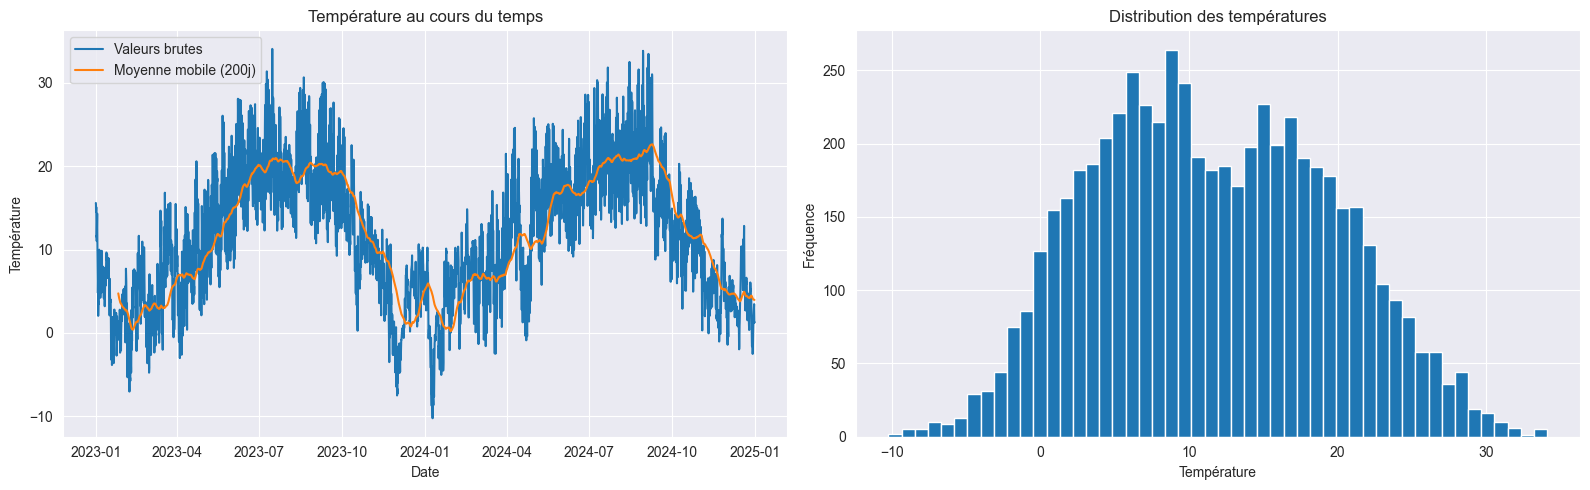

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Premier graphique : série temporelle
axes[0].plot(df_y.index, df_eda['y'], label='Valeurs brutes')
axes[0].plot(df_y.index, df_eda['y'].rolling(window=200).mean(), label='Moyenne mobile (200j)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Température')
axes[0].set_title('Température au cours du temps')
axes[0].legend()

# Deuxième graphique : histogramme
axes[1].hist(df_y['y'], bins=50)
axes[1].set_title('Distribution des températures')
axes[1].set_xlabel('Température')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()


La série n’est pas stationnaire.

On observe une forte saisonnalité avec des cycles annuels bien marqués: la moyenne et la variance évoluent clairement au fil du temps, ce qui viole les conditions de stationnarité.

Le graphique de droite montre une distribution bimodale des températures avec deux pics distincts. Le premier pic se situe autour de 5-10°C (probablement les températures hivernales) et le second autour de 15-20°C (températures estivales).

Cette forme bimodale confirme la forte saisonnalité observée dans la série temporelle : les températures se regroupent principalement autour de deux valeurs caractéristiques correspondant aux saisons froides et chaudes.

La distribution couvre une amplitude importante (-10°C à 30°C), ce qui illustre bien la variabilité saisonnière importante de cette série de températures. Cette caractéristique bimodale est typique des données climatiques dans les régions à saisons marquées.

 > On observe que les températures descendent parfois proches de 0°C, voire en dessous. Cela signifie que l’indicateur MAPE pourra être trompeur lors de l’évaluation des modèles, car il devient très élevé pour les valeurs basses. Il sera donc plus pertinent d’interpréter le MAE (erreur absolue moyenne en °C) pour juger la qualité des prédictions.

In [67]:
Q1 = df_eda.quantile(0.25)
Q3 = df_eda.quantile(0.75)
IQR = Q3 - Q1
outliers = (df_eda < (Q1 - 1.5 * IQR)) | (df_eda > (Q3 + 1.5 * IQR))

In [68]:
serie_corrigee = df_y.copy()
serie_corrigee[outliers] = np.nan
serie_corrigee = serie_corrigee.interpolate()

nb_outliers = outliers.sum().iloc[0]

print(f"Nombre d'outliers détectés : {nb_outliers}")
print(f"Pourcentage : {(nb_outliers/len(serie_corrigee))*100:.2f}%")

Nombre d'outliers détectés : 0
Pourcentage : 0.00%


Aucun outlier n’a été détecté dans notre série. Cela signifie que toutes les valeurs sont cohérentes avec la distribution globale des données.

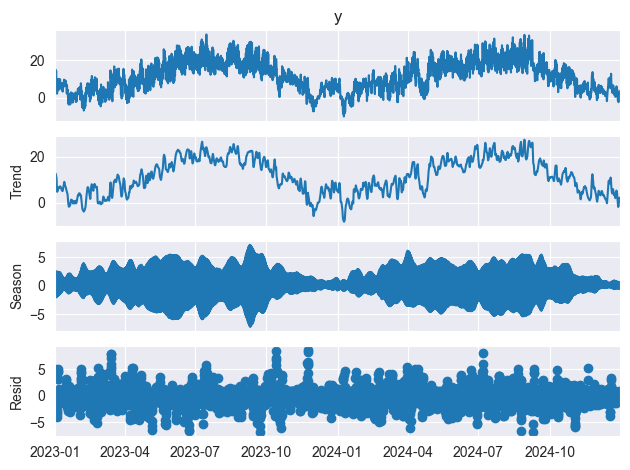

In [69]:
stl = STL(
    df_eda['y'],
    period=8,
    seasonal=13,
    robust=True
)
r_stl = stl.fit()

r_stl.plot()
plt.show()

- La tendance montre une évolution globale, avec une montée puis une descente sur la période.
- La saisonnalité est bien marquée et régulière.
- Les résidus sont centrés autour de zéro, sans motif évident, ce qui indique que la STL a bien extrait la tendance et la saisonnalité.

In [70]:
check_stationarity(r_stl.resid)


════════════════════════════════════════
📊 TEST ADF - AUGMENTED DICKEY-FULLER
════════════════════════════════════════
Hypothèse nulle (H0) : La série a une racine unitaire (non stationnaire)

Statistique ADF : -12.2704
p-value : 0.0000
Valeurs critiques :
  1%% : -3.4315
  5%% : -2.8620
  10%% : -2.5670

Conclusion ADF : Stationnaire (α=0.05)


True

In [71]:
check_stationarity_kpss(r_stl.resid)


════════════════════════════════════════
📈 TEST KPSS - KWiatkowski-Phillips-Schmidt-Shin
════════════════════════════════════════
Hypothèse nulle (H0) : La série est stationnaire autour d'une constante

Statistique KPSS : 0.0598
p-value : 0.1000
Valeurs critiques :
  10%% : 0.3470
  5%% : 0.4630
  2.5%% : 0.5740
  1%% : 0.7390

Conclusion KPSS : Stationnaire (α=0.05)


True

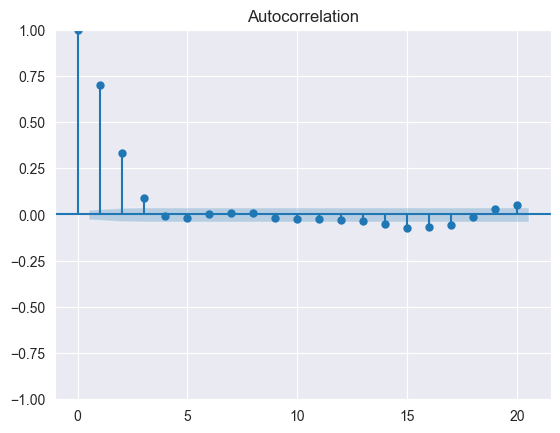

In [72]:
residus = r_stl.resid.dropna()

# Graphique ACF
plot_acf(residus, lags=20)
plt.show()

**Autocorrélation significative** : les 4 premiers lags dépassent les bandes de confiance (lignes horizontales). Cela signifie qu'il reste de la structure temporelle dans les résidus que la décomposition STL n'a pas capturée.

In [73]:
from statsmodels.stats.diagnostic import acorr_ljungbox
dernier_lag = 10

test_result = acorr_ljungbox(residus, lags=10, return_df=True)
pvalue = test_result['lb_pvalue'].iloc[-1]
print(f"Ljung-Box (lag={dernier_lag}) : p-value = {pvalue:.4f}")
if pvalue < 0.05:
    print("→ Résidus autocorrélés : le modèle n'explique pas toute la structure.")
else:
    print("→ Résidus = bruit blanc : pas d'autocorrélation détectée.")

Ljung-Box (lag=10) : p-value = 0.0000
→ Résidus autocorrélés : le modèle n'explique pas toute la structure.


Cette situation n'est pas nécessairement problématique en soi, mais représente plutôt une opportunité d'amélioration. Les résidus autocorrélés contiennent des informations prédictives précieuses qui peuvent être exploitées pour enrichir les prévisions finales.

La solution la plus recommandée consiste à adopter une approche hybride STL-ARIMA qui tire parti de la structure autocorrélative des résidus.

## 4. Préparation des Données pour ML

### 4.1 Nettoyage des données

In [81]:
df_eda = nan_interpolation_linear(df_eda, 'y')
df_eda = nan_interpolation_linear(df_eda, 'relative_humidity_2m')

### 4.2 Division train/validation/test

In [82]:
train_size = int(len(df_y) * 0.9)

In [83]:
df_model = df_eda.reset_index().rename(columns={'index': 'ds'}).copy()

train = df_model[:train_size]
test = df_model[train_size:]

print("DATA:", train.shape, test.shape)

DATA: (5256, 4) (585, 4)


## 5. Modélisation - Méthodes Statistiques

Les approches à ARIMA SARIMA ET SARIMAX on ete tester avec un recherche des parametre faite avec l'aide de optuna et une decoupe de dataset manuelle et et avec timesplit séries. Tout a echouer a des scores MAPE de plus de 200%

### ARIMA

Application du modèle ARIMA sur les données prétraitées, sans décomposition préalable par STL.

In [47]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 1)
        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(0, 0, 0, 0),
            trend=trend
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [49]:
name_model = 'ARIMA'
arima = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(0,0,0,0),
            trend=study.best_params['trend']
        )
r_arima = arima.fit()

In [50]:
p_arima = r_arima.get_forecast(steps=len(test))

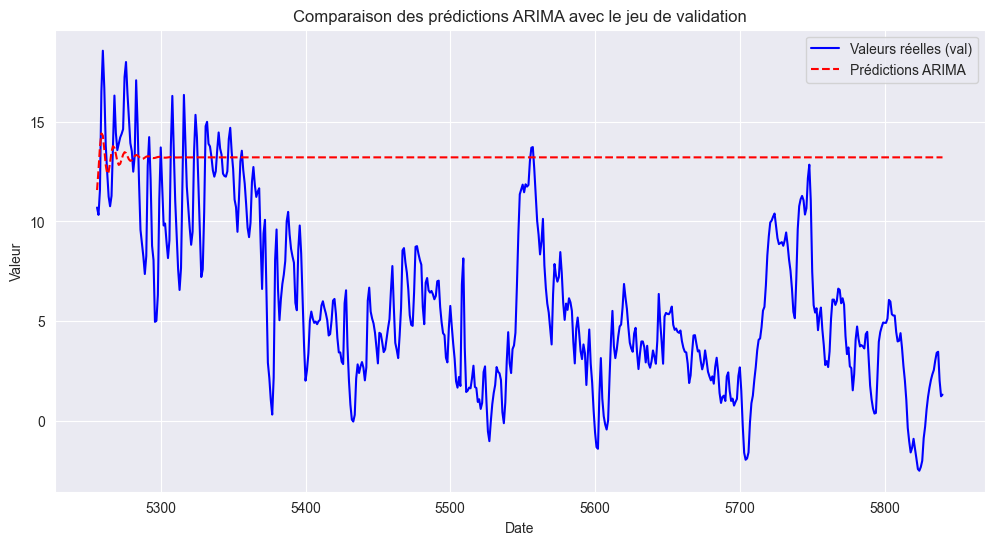

In [51]:
match_val_predict(p_arima.predicted_mean, test['y'], name_model).show()

In [52]:
m_arima = metrics_result(p_arima.predicted_mean, test['y'])

Le modèle ARIMA ne parvient pas à suivre la variabilité des valeurs réelles: il prédit une valeur quasi constante, ce qui explique les erreurs élevées observées (MAE: 7.95, RMSE: 8.86, MAPE: 881.73%).

### SARIMA

Application du modèle SARIMA sur les données prétraitées, sans décomposition préalable par STL.

In [53]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, 8),
            trend=trend
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [54]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

Trial 5 failed with parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 3, 'D': 2, 'Q': 2, 'trend': 'c'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\NeoSk\AppData\Local\Temp\ipykernel_17000\3291217407.py", line 27, in objective
    results = model.fit(disp=False)
              ^^^^^^^^^^^^^^^^^^^^^
  File "C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 729, in fit
    res = func(mlefit.params, transformed=False, includes_fixed=False,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 890, in smooth
    return self._wrap_results(params, result, return_ssm, cov_type,
           ^^^

KeyboardInterrupt: 

In [31]:
name_model = 'SARIMA'
sarima = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(study.best_params['P'], study.best_params['D'], study.best_params['Q'], 8),
            trend=study.best_params['trend']
        )
r_sarima = sarima.fit()

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


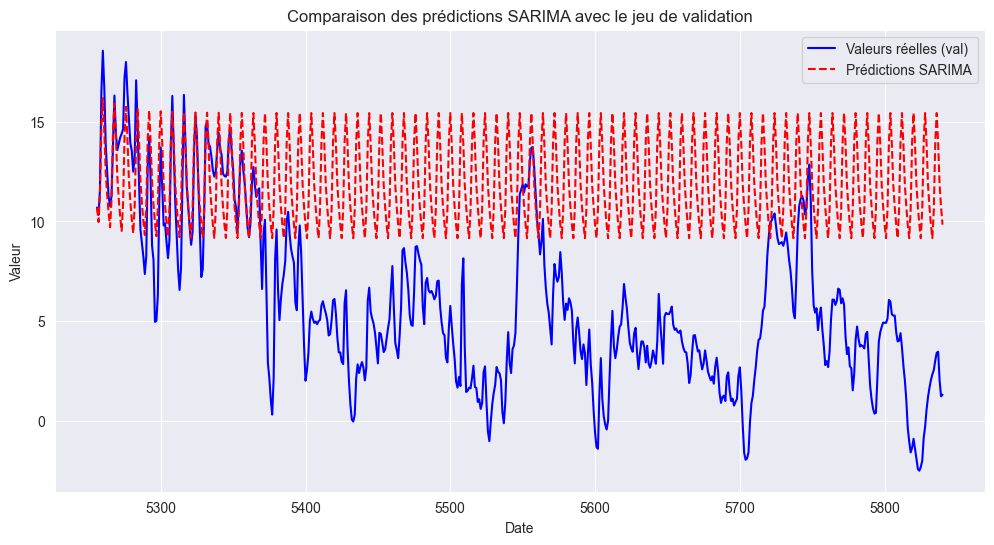

In [32]:
p_sarima = r_sarima.get_forecast(steps=len(test))

match_val_predict(p_sarima.predicted_mean, test['y'], name_model).show()

In [33]:
m_sarima = metrics_result(p_sarima.predicted_mean, test['y'])

Le modèle SARIMA ne parvient pas à suivre la variabilité des valeurs réelles : ses prédictions restent quasi constantes et ne capturent ni les fluctuations ni les tendances du jeu de validation. Cela montre que SARIMA, dans sa configuration actuelle, n’est pas adapté à la complexité ou à la forte variabilité de cette série temporelle

### SARIMAX

Application du modèle SARIMAX sur les données prétraitées, sans décomposition préalable par STL.

In [34]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, 8),
            trend=trend,
            exog=train_tss['relative_humidity_2m']
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [35]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [36]:
name_model='SARIMAX'
sarimax = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(study.best_params['P'],  study.best_params['D'], study.best_params['Q'], 8),
            trend=study.best_params['trend'],
            exog=train['relative_humidity_2m']
        )
r_sarimax = sarima.fit()

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


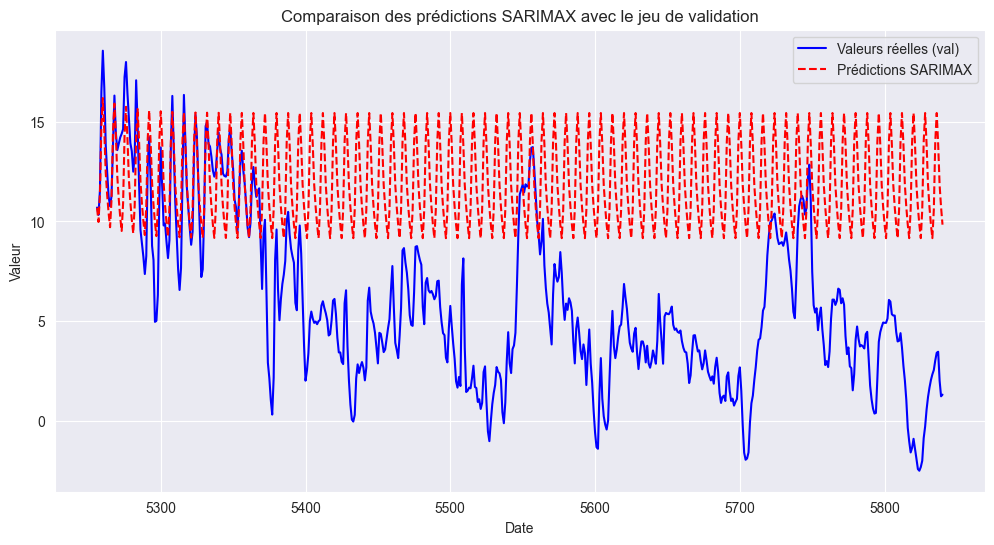

In [37]:
p_sarimax = r_sarimax.get_forecast(steps=len(test))

match_val_predict(p_sarimax.predicted_mean, test['y'], name_model).show()

In [38]:
m_sarimax = metrics_result(p_sarimax.predicted_mean, test['y'])

### STL+ARIMA

Au vu des limites du modèle SARIMA à capturer la variabilité des données et des résultats des tests de diagnostic, l'approche hybride STL-ARIMA est fortement recommandée. Les tests révèlent que :

Analyse des résidus : Le test de Ljung-Box (p-value = 0.0000) confirme que les résidus sont significativement autocorrélés, indiquant que le modèle SARIMA n'explique pas toute la structure temporelle des données.

Tests de stationnarité : Avant décomposition STL, les résultats sont contradictoires (ADF stationnaire vs KPSS non-stationnaire), suggérant une stationnarité de tendance. Après décomposition STL, les deux tests concordent (ADF et KPSS stationnaires), confirmant que STL améliore efficacement les propriétés statistiques des données.

Cette concordance des tests post-STL et la persistance d'autocorrélation dans les résidus justifient l'adoption d'une approche hybride pour mieux capturer les patterns complexes de la série temporelle.

In [39]:
stl_arima_train = STL(train['y'], period=8)
r_train_stl_arima = stl_arima_train.fit()

stl_arima_test = STL(test['y'], period=8)
r_test_stl_arima = stl_arima_test.fit()

In [40]:
train_stl_arima = pd.DataFrame(r_train_stl_arima.resid)
test_stl_arima = pd.DataFrame(r_test_stl_arima.resid)

train_stl_arima = train_stl_arima.rename(columns={'resid': 'y'})
test_stl_arima = test_stl_arima.rename(columns={'resid': 'y'})


In [41]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train_stl_arima):
        train_tss, val_tss = train_stl_arima.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss,
            order=(p, d, q),
            seasonal_order=(0, 0, 0, 0),
            trend=trend,
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [42]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [43]:
name_model='STL-ARIMA'
stl_arima = SARIMAX(
    train_stl_arima,
    order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
    seasonal_order=(0, 0, 0, 0),
    trend=study.best_params['trend']
)
r_stl_arima = stl_arima.fit()


C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
p_stl_arima = r_stl_arima.get_forecast(steps=len(test))

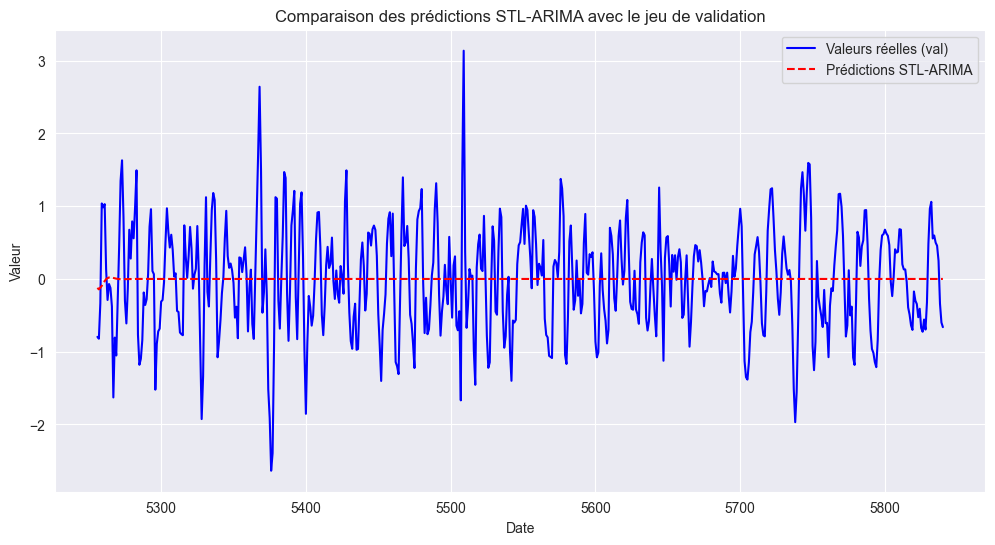

In [45]:
match_val_predict(p_stl_arima.predicted_mean, test_stl_arima['y'], name_model).show()

In [46]:
m_stl_arima = metrics_result(p_stl_arima.predicted_mean, test_stl_arima['y'])

Le modèle STL-ARIMA s'avère inadapté pour cette série temporelle.
Les métriques catastrophiques (MAPE 99.6%, R² ≈ 0) confirment
l'échec total du modèle à capturer les dynamiques temporelles.

## 6. Modélisation - Machine Learning

In [84]:
df_ml_model = df_eda.reset_index().rename(columns={'index': 'ds'}).copy()

df_ml_model.drop('unique_id', axis=1, inplace=True)

train_ml = df_ml_model[:train_size].copy()
test_ml = df_ml_model[train_size:].copy()

train_ml_without_exog = train_ml.drop('relative_humidity_2m', axis=1).copy()
test_ml_without_exog = test_ml.drop('relative_humidity_2m', axis=1).copy()

print("DATA:", train.shape, test.shape)

DATA: (5256, 4) (585, 4)


### XGBoost

In [85]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Paramètres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Paramètres XGBoost
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 4, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    subsample = trial.suggest_float('subsample', 0.7, 0.9)

    train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Créer les lag features
        lag_transformer = LagFeatures(
            variables= ['y'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y'])
        y_val = val_transformed['y']

        # Entraînement
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42,
            eval_metric='rmse',
        )

        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)


In [86]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

Best trial: 86. Best value: 1.80526: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


In [87]:
best_n_lags = study.best_params['n_lags']

best_params = study.best_params.copy()
best_params.pop('n_lags', None)

9

In [88]:
name_model='XGBRegressor'
train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml_without_exog.select_dtypes(include=['number']).copy()

xgb_transformer = LagFeatures(
    variables=['y'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_xgb = xgb_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_xgb = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_xgb = xgb_transformer.transform(test_transformed_xgb).iloc[best_n_lags:].dropna()

X_train_xgb = train_transformed_xgb.drop(columns=['y'])
y_train_xgb = train_transformed_xgb['y']

tscv = TimeSeriesSplit(n_splits=2)
train_indices, val_indices = next(iter(tscv.split(X_train_xgb)))

X_tr = X_train_xgb.iloc[train_indices]
y_tr = y_train_xgb.iloc[train_indices]
X_val = X_train_xgb.iloc[val_indices]
y_val = y_train_xgb.iloc[val_indices]


X_test_xgb = test_transformed_xgb.drop(columns=['y'])
y_test_xgb = test_transformed_xgb['y']

xgb_r = XGBRegressor(
            **best_params,
            eval_metric='rmse',
            early_stopping_rounds=10,
            random_state=42
        )
xgb_r.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
)

[0]	validation_0-rmse:7.36835
[1]	validation_0-rmse:6.77273
[2]	validation_0-rmse:6.23241
[3]	validation_0-rmse:5.74058
[4]	validation_0-rmse:5.30257
[5]	validation_0-rmse:4.90958
[6]	validation_0-rmse:4.54190
[7]	validation_0-rmse:4.22043
[8]	validation_0-rmse:3.92541
[9]	validation_0-rmse:3.65109
[10]	validation_0-rmse:3.40641
[11]	validation_0-rmse:3.18766
[12]	validation_0-rmse:2.99741
[13]	validation_0-rmse:2.82292
[14]	validation_0-rmse:2.67562
[15]	validation_0-rmse:2.53269
[16]	validation_0-rmse:2.39963
[17]	validation_0-rmse:2.28466
[18]	validation_0-rmse:2.18225
[19]	validation_0-rmse:2.10924
[20]	validation_0-rmse:2.02832
[21]	validation_0-rmse:1.95975
[22]	validation_0-rmse:1.90174
[23]	validation_0-rmse:1.84847
[24]	validation_0-rmse:1.80730
[25]	validation_0-rmse:1.76356
[26]	validation_0-rmse:1.72272
[27]	validation_0-rmse:1.69691
[28]	validation_0-rmse:1.67078
[29]	validation_0-rmse:1.64618
[30]	validation_0-rmse:1.62192
[31]	validation_0-rmse:1.60559
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09039836232253898, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, ...)

In [89]:
p_xgb = xgb_r.predict(X_test_xgb)

In [96]:
m_xgb = metrics_result(p_xgb, y_test_xgb)
print(m_xgb)
correlation = np.corrcoef(y_test_xgb[:-1], y_test_xgb[1:])[0,1]
print(f"Corrélation temporelle : {correlation:.3f}")
# Testez un modèle naïf (persistance)
naive_pred = y_test_xgb.shift(1).dropna()
naive_r2 = r2_score(y_test_xgb[1:], naive_pred)
print(f"R² naïf: {naive_r2:.3f}")


{'MAPE': 55.81540939172408, 'MAE': 0.8427249806728797, 'RMSE': 1.07971613129055, 'R2': 0.9351013958995666}
Corrélation temporelle : 0.953
R² naïf: 0.906


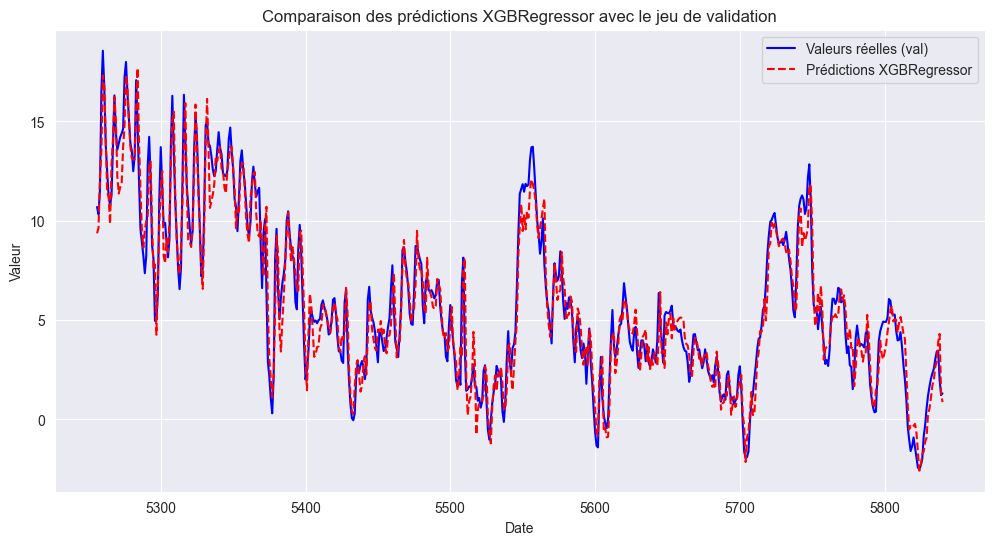

In [91]:
match_val_predict(p_xgb, y_test_xgb, name_model).show()

Les scores sont très bons et la courbe de validation montre que le modèle XGB généralise bien sur ce jeu. Il faut cependant rester attentif à l’overfitting, et vérifier que la séparation train/val est correcte et qu’il n’y a pas eu de fuite de données.Le MAPE élevé indique que le modèle a plus de mal sur les petites valeurs.

### XGBoost + Exogène

In [55]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Paramètres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Paramètres XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    train_ml_numeric = train_ml.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Créer les lag features
        lag_transformer = LagFeatures(
            variables= ['y', 'relative_humidity_2m'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y', 'relative_humidity_2m'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y', 'relative_humidity_2m'])
        y_val = val_transformed['y']

        # Entraînement
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)


In [56]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 46. Best value: 1.89776: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


In [57]:
best_n_lags = study.best_params['n_lags']
best_params = study.best_params.copy()
best_params.pop('n_lags', None)

10

In [58]:
name_model='XGBRegressor-exog'

train_ml_numeric = train_ml.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml.select_dtypes(include=['number']).copy()

xgb_transformer = LagFeatures(
    variables=['y', 'relative_humidity_2m'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_xgb = xgb_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_xgb = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_xgb = xgb_transformer.transform(test_transformed_xgb).iloc[best_n_lags:].dropna()

X_train_xgb = train_transformed_xgb.drop(columns=['y', 'relative_humidity_2m'])
y_train_xgb = train_transformed_xgb['y']

X_test_xgb = test_transformed_xgb.drop(columns=['y', 'relative_humidity_2m'])
y_test_xgb = test_transformed_xgb['y']

xgb_r = XGBRegressor(**best_params, random_state=42)
xgb_r.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09623746530781094, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=228, n_jobs=None,
             num_parallel_tree=None, ...)

In [59]:
p_xgb = xgb_r.predict(X_test_xgb)

In [60]:
m_xgb = metrics_result(p_xgb, y_test_xgb)
correlation = np.corrcoef(y_test_xgb[:-1], y_test_xgb[1:])[0,1]
print(f"Corrélation temporelle : {correlation:.3f}")
# Testez un modèle naïf (persistance)
naive_pred = y_test_xgb.shift(1).dropna()
naive_r2 = r2_score(y_test_xgb[1:], naive_pred)
print(f"R² naïf: {naive_r2:.3f}")

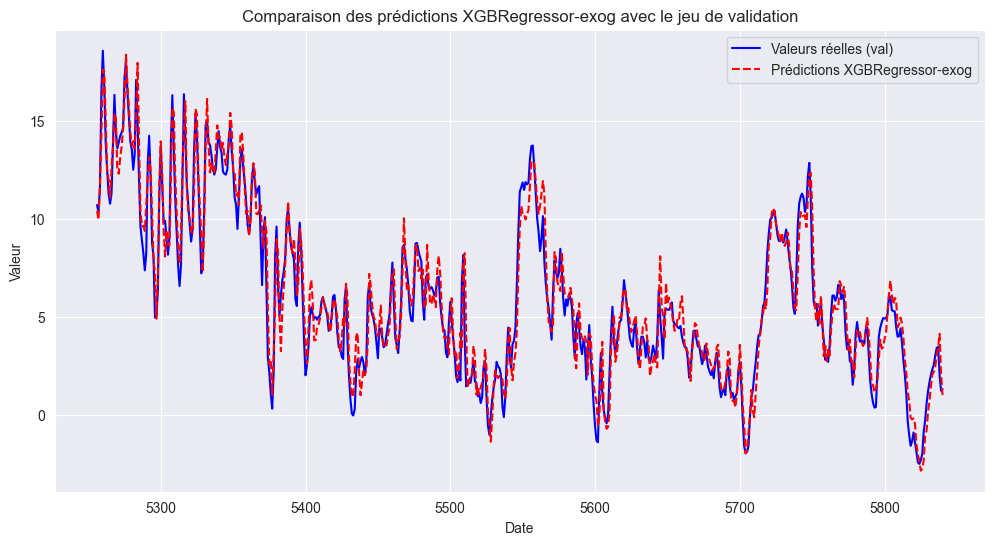

In [61]:
match_val_predict(p_xgb, y_test_xgb, name_model).show()

L'expérimentation avec variables exogènes a été menée mais n'a pas apporté de gain de performance. Cela suggère que l'information pertinente est déjà captée par les lags de la température.

### Random Forest

In [62]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Paramètres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Paramètres Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    max_samples = trial.suggest_float('max_samples', 0.6, 1.0)

    train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Créer les lag features
        lag_transformer = LagFeatures(
            variables=['y'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y'])
        y_val = val_transformed['y']

        # Entraînement
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            max_samples=max_samples,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)

In [63]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 87. Best value: 2.17431: 100%|██████████| 100/100 [07:53<00:00,  4.74s/it]


In [64]:
best_n_lags = study.best_params['n_lags']

best_params = study.best_params.copy()
best_params.pop('n_lags', None)

10

In [65]:
name_model='RandomForestRegressor'

train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml_without_exog.select_dtypes(include=['number']).copy()

rf_transformer = LagFeatures(
    variables=['y'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_rf = rf_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_rf = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_rf = rf_transformer.transform(test_ml_numeric).iloc[best_n_lags:].dropna()

X_train_rf = train_transformed_rf.drop(columns=['y'])
y_train_rf = train_transformed_rf['y']

X_test_rf = test_transformed_rf.drop(columns=['y'])
y_test_rf = test_transformed_rf['y']

r_rf = RandomForestRegressor(**best_params, random_state=42)
r_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=8, max_features=0.8765918836413475,
                      max_samples=0.8034912613018732, n_estimators=242,
                      random_state=42)

In [66]:
p_rf = r_rf.predict(X_test_rf)

In [67]:
m_rf = metrics_result(p_rf, y_test_rf)
correlation = np.corrcoef(y_test_rf[:-1], y_test_rf[1:])[0,1]
print(f"Corrélation temporelle : {correlation:.3f}")
# Testez un modèle naïf (persistance)
naive_pred = y_test_rf.shift(1).dropna()
naive_r2 = r2_score(y_test_rf[1:], naive_pred)
print(f"R² naïf: {naive_r2:.3f}")

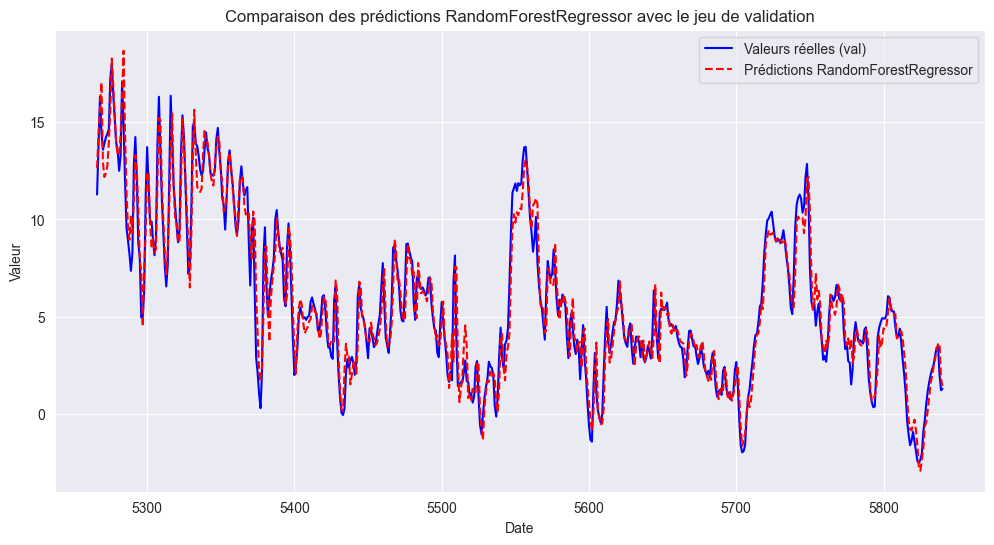

In [68]:
match_val_predict(p_rf, y_test_rf, name_model).show()

Le Random Forest capture très bien la dynamique de la série temporelle, mais il faut rester prudent avec l’interprétation du MAPE dans ce contexte. Les autres métriques et la visualisation montrent que le modèle est performant sur ce jeu de validation.